In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import math

In [44]:
def gender_map(x):
    if math.isclose(x, 0.48246):
        return 'Female'
    else:
        return 'Male'

In [45]:
def country_map(x):
    countries = [(-0.09765, 'Australia'), (0.24923,'Canada'), 
               (-0.46841,'New Zealand'), (0.21128,'Republic of Ireland'), 
               (0.96082,'UK'), (-0.57009,'USA'), (-0.28519,'Other')]
    for (value, country) in countries:
        if math.isclose(x, value):
            return country;
    return None

In [46]:
# Function to determine illegal drug usage per person
def is_drug_user(row):
    row = row['Amphet':]
    num_zeros = (row == 0).astype(bool).sum()
    if num_zeros == row.size:
        return False
    return True

In [47]:
train_data = pd.read_csv("train_data.csv", delimiter='\t', index_col=0)
test_data = pd.read_csv("test_data.csv", delimiter='\t', index_col=0)

In [48]:
def create_plot(ax, data, color='#99004f'):
    usage = data.apply(pd.Series.value_counts, axis=0)
    drug = usage.iloc[:,0].name
    usages = usage.sort_index().iloc[:,0].values
    width = 0.05
    xpos = np.arange(len(usage.index),dtype='float64')
    xpos *= 0.10
    ax.bar(xpos, usages, width=width, color=color)
    rects = ax.patches
    for rect, usage in zip(rects,usages):
        x = rect.get_x() + rect.get_width()/2
        y = rect.get_height() + 0.5
        ax.text(x, y, usage, ha='center',va='bottom', fontsize=5)
    
    usage_texts = ['Never Used','Decade Ago','Last Decade', 
                   'Last Year', 'Last Month', 
                   'Last Week', 'Last Day']
    ax.set_ylim(bottom=0, top=1800)
    ax.set_xticks(xpos)
    ax.set_xticklabels(usage_texts)
    ax.tick_params(axis='y', labelsize=4)
    ax.tick_params(axis ='x', labelrotation=15, labelsize=4, width=0.7)
    ax.text(0.5, 0.9, drug, horizontalalignment='center', 
            transform=ax.transAxes, fontsize=9)

In [49]:
def create_usage_subplots(data):
    
    colors = ['#99004f', '#007acc', '#009900', '#e67300',
              '#cc0000','#0000b3', '#7a00cc', '#e6e600',
              '#2eb8b8']
    
    data = data.rename(columns={'Amphet':'Amphetamine', 'Amyl':'Amyl Nitrite',
            'Benzos':'Benzodiazepine','Caff':'Caffeine','Coke':'Cocaine',
            'Meth':'Methamphetamine'})
    
    
    drug_data = data.loc[:,'Alcohol':].apply(lambda series: series.astype(bool).sum(),axis=0)
    drug_data = drug_data.sort_values(ascending=False)
    
    drugs = drug_data.index.values

    nrows = 5
    ncols= 4
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=True, figsize=(10,8))
    plt.subplots_adjust(wspace=0.02, hspace= 0.3, top = 0.95)
    color_idx = 0
    i = 0
    for row in range(nrows):
        for col in range(ncols):
            if col != 0:
                axs[row, col].tick_params(axis='y', width=0)
            if i >= len(drugs):
                axs[row, col].set_visible(False)
            else:
                create_plot(axs[row, col], data[[drugs[i]]], colors[color_idx])
            i += 1
            color_idx = (color_idx+1)%len(colors)
    fig.savefig('figures/drugs.png', dpi=300)
    plt.show()
    plt.clf()

In [50]:
plot_data = pd.read_csv('drug_consumption.csv')
mpl.rcParams['axes.linewidth'] = 0.5

In [51]:
# label encode categorical variables
for column in plot_data.loc[:,'Alcohol':'VSA']:
    # get label encoding for column
    plot_data[column] = plot_data[column].astype('category').cat.codes
    # convert column to numeric type
    plot_data[column] = plot_data[column].astype('int32')

In [52]:
# drop fake drug
del plot_data['Semer'] 
# drop ID variable
del plot_data['ID']
# drop chocolate
del plot_data['Choc']

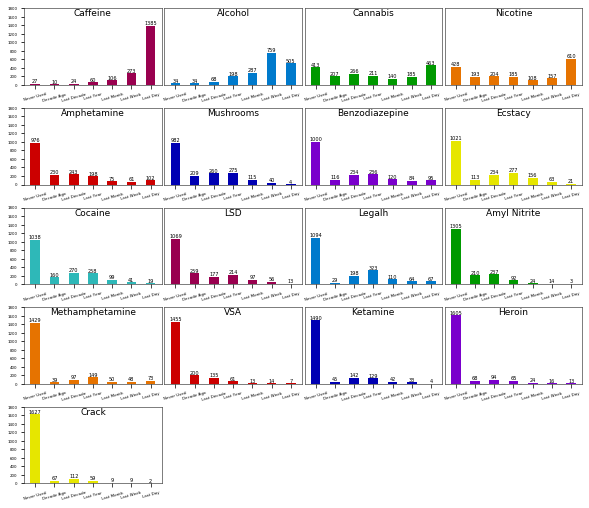

<Figure size 432x288 with 0 Axes>

In [53]:
create_usage_subplots(plot_data)

In [54]:
min_score = plot_data.loc[:,'Nscore':'Cscore'].min().values.min()
plot_data.loc[:,'Nscore':'Cscore'] += abs(min_score)

In [55]:
plot_data['Drug User'] = plot_data.drop(['Alcohol', 'Nicotine','Caff'], axis=1).apply(is_drug_user, axis=1)
plot_data['Gender']= plot_data['Gender'].apply(gender_map)
plot_data['Country']=plot_data['Country'].apply(country_map)

In [56]:
# Create dataset for drug users
users = plot_data.loc[plot_data['Drug User'] == True]
# Create dataset for non-drug users
nonusers = plot_data.loc[plot_data['Drug User'] == False]

In [57]:
# Get data for male drug users
male_users = users.loc[(users['Gender'] == 'Male')]
male_users = male_users.reset_index(drop=True)

In [58]:
# Get data for female drug users
female_users = users.loc[(users['Gender'] == 'Female')]
female_users = female_users.reset_index(drop=True)

In [59]:
def create_personality_plot(users, nonusers):
    traits = ['Neuroticism', 'Extraversion', 'Openness', 
              'Agreeablenes', 'Conscientiousnes']
    users_scores = users.loc[:,'Nscore':'Cscore'].mean().values
    nonusers_scores = nonusers.loc[:,'Nscore':'Cscore'].mean().values
    width = 0.3
    users_xpos = np.arange(len(users_scores))
    nonusers_xpos = [x + width for x in users_xpos]
    
    plt.bar(users_xpos, users_scores, width=width, color=['#007acc'], label='Users')
    plt.bar(nonusers_xpos, nonusers_scores, width=width, color=['#009900'], label='Non-users')
    ax = plt.gca()
    rects = ax.patches
    for rect, score in zip(rects[:5],users_scores):
        x = rect.get_x() + rect.get_width()/2
        y = rect.get_height() + 0.05
        ax.text(x, y, np.round(score, 2), ha='center',va='bottom', fontsize=10)
    for rect, score in zip(rects[5:],nonusers_scores):
        x = rect.get_x() + rect.get_width()/2
        y = rect.get_height() + 0.05
        ax.text(x, y, np.round(score, 2), ha='center',va='bottom', fontsize=10)
    plt.title('Personality Trait Scores for Illegal Drug Users')
    plt.xlabel('Personality Traits')
    plt.ylabel('Mean Scores')
    plt.xticks(users_xpos, traits)
    plt.legend(loc='upper center', bbox_to_anchor=(1.2, 0.9), shadow=True, ncol=1)
    fig = plt.gcf()
    fig.set_size_inches(10,9)
    plt.savefig('figures/traits.png', dpi=300)
    plt.show()
    plt.clf()

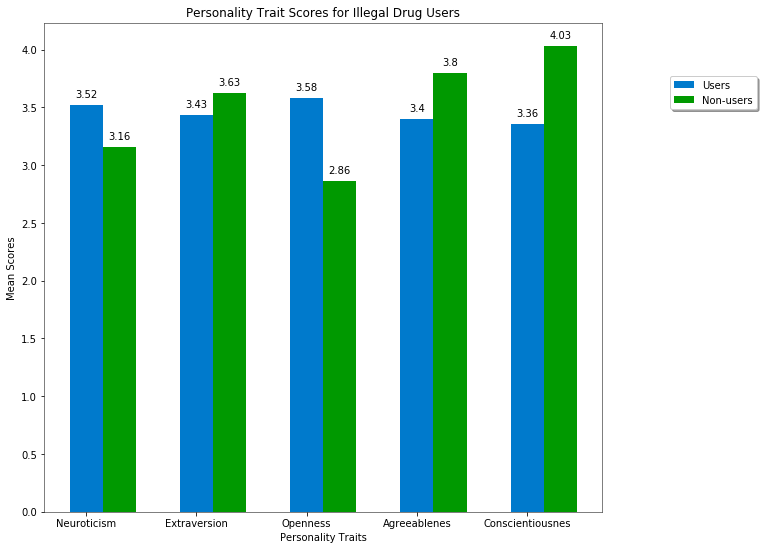

<Figure size 432x288 with 0 Axes>

In [60]:
create_personality_plot(users, nonusers)

In [61]:
def create_gender_plot(male_users, female_users):
    xpos = np.arange(2)
    bars = [len(male_users.index), len(female_users.index)]
    
    plt.bar(xpos, bars, width=0.3, color=['#2eb8b8','#99004f'], align='center')
    plt.xticks(xpos, ['Male', 'Female'])
    plt.title('Illegal Drug Usage by Gender')
    plt.ylabel('Users')
    fig = plt.gcf()
    fig.set_size_inches(8,6)
    plt.savefig('figures/genders.png', dpi=300)
    plt.show()
    plt.clf()

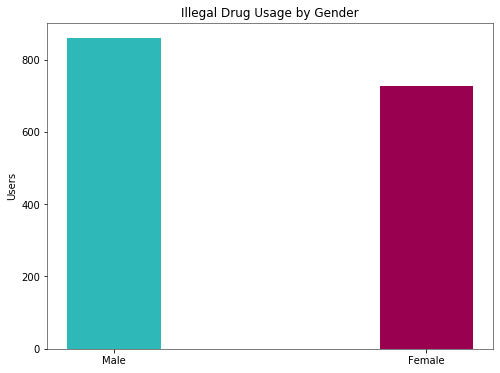

<Figure size 432x288 with 0 Axes>

In [62]:
create_gender_plot(male_users, female_users)

In [21]:
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 32 columns):
ID           1319 non-null int64
Age          1319 non-null float64
Gender       1319 non-null float64
Education    1319 non-null float64
Country      1319 non-null float64
Ethnicity    1319 non-null float64
Nscore       1319 non-null float64
Escore       1319 non-null float64
Oscore       1319 non-null float64
Ascore       1319 non-null float64
Cscore       1319 non-null float64
Impulsive    1319 non-null float64
SS           1319 non-null float64
Alcohol      1319 non-null object
Amphet       1319 non-null object
Amyl         1319 non-null object
Benzos       1319 non-null object
Caff         1319 non-null object
Cannabis     1319 non-null object
Choc         1319 non-null object
Coke         1319 non-null object
Crack        1319 non-null object
Ecstacy      1319 non-null object
Heroin       1319 non-null object
Ketamine     1319 non-null object
Legalh       1319 non-null objec

In [23]:
# Drop ID, Chocolate, the fake drug Semer, and legal substances
train_data.drop(['ID', 'Choc', 'Semer', 'Alcohol', 'Nicotine', 'Caff','Legalh'], axis=1, inplace=True)
test_data.drop(['ID', 'Choc', 'Semer', 'Alcohol', 'Nicotine', 'Caff','Legalh'], axis=1, inplace=True)

In [24]:
for column in train_data.loc[:,'Amphet':]:
    # get label encoding for column
    train_data[column] = train_data[column].astype('category').cat.codes.astype('int32')
    test_data[column] = test_data[column].astype('category').cat.codes.astype('int32')

In [25]:
# Combine illegal drug usage into a single boolean variable
train_data['Drug User'] = train_data.apply(is_drug_user, axis=1)
test_data['Drug User'] = test_data.apply(is_drug_user, axis=1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 26 columns):
Age          1319 non-null float64
Gender       1319 non-null float64
Education    1319 non-null float64
Country      1319 non-null float64
Ethnicity    1319 non-null float64
Nscore       1319 non-null float64
Escore       1319 non-null float64
Oscore       1319 non-null float64
Ascore       1319 non-null float64
Cscore       1319 non-null float64
Impulsive    1319 non-null float64
SS           1319 non-null float64
Amphet       1319 non-null int32
Amyl         1319 non-null int32
Benzos       1319 non-null int32
Cannabis     1319 non-null int32
Coke         1319 non-null int32
Crack        1319 non-null int32
Ecstacy      1319 non-null int32
Heroin       1319 non-null int32
Ketamine     1319 non-null int32
LSD          1319 non-null int32
Meth         1319 non-null int32
Mushrooms    1319 non-null int32
VSA          1319 non-null int32
Drug User    1319 non-null bool
dtypes: bool

In [26]:
X_train = train_data.loc[:,'Age':'SS']
y_train = train_data['Drug User']

In [27]:
# Feature selection
sel = SelectFromModel(RandomForestClassifier(random_state=0), threshold=0.05)
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat.values)

['Age' 'Education' 'Country' 'Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore'
 'Impulsive' 'SS']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [28]:
# Grid search for random forest
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 100, num = 20)] + [None]
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 20)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
grid = {'max_features': max_features,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

In [29]:
# Base classifier used for grid search
forest = RandomForestClassifier(random_state=0)
# Use 100 iterations and 10-fold cross-validation, using 4 cores
forest_grid_search = RandomizedSearchCV(estimator = forest, param_distributions = grid, 
                               n_iter = 100, cv = 10, verbose=2, random_state=0, n_jobs = 4)

In [30]:
# Use features selected for training and testing
X_train = train_data[selected_feat.values]
y_train = train_data['Drug User']

X_test = test_data[selected_feat.values]
y_test = test_data['Drug User']

In [31]:
# Fit features selected to grid search (slow process)
forest_grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  6.8min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=Non

In [32]:
# Store the dictionary of best parameters
params = forest_grid_search.best_params_
params

{'n_estimators': 384,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [33]:
search_data = pd.DataFrame(forest_grid_search.cv_results_)
search_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
mean_fit_time              100 non-null float64
std_fit_time               100 non-null float64
mean_score_time            100 non-null float64
std_score_time             100 non-null float64
param_n_estimators         100 non-null object
param_min_samples_split    100 non-null object
param_min_samples_leaf     100 non-null object
param_max_features         100 non-null object
param_max_depth            93 non-null object
param_bootstrap            100 non-null object
params                     100 non-null object
split0_test_score          100 non-null float64
split1_test_score          100 non-null float64
split2_test_score          100 non-null float64
split3_test_score          100 non-null float64
split4_test_score          100 non-null float64
split5_test_score          100 non-null float64
split6_test_score          100 non-null float64
split7_test_score          100 non-null 

In [34]:
# Convert estimators column to integer type
search_data['param_n_estimators'] = search_data['param_n_estimators'].astype('int32')

In [35]:
estimators = search_data[['param_n_estimators', 'mean_fit_time', 'mean_test_score']].sort_values(
    by=['param_n_estimators'])
estimators.head

<bound method NDFrame.head of     param_n_estimators  mean_fit_time  mean_test_score
37                 100       0.248846         0.840788
64                 100       0.286699         0.844579
94                 100       0.267994         0.843821
66                 147       0.379400         0.840788
26                 147       0.386410         0.846096
..                 ...            ...              ...
6                 1000       2.441276         0.842305
5                 1000       2.516215         0.846096
1                 1000       2.861952         0.842305
17                1000       2.622465         0.848370
41                1000       2.523083         0.847612

[100 rows x 3 columns]>

In [36]:
max_depths = search_data[['param_max_depth', 'mean_test_score']]
# Remove rows with max depth of None for plotting
max_depths = max_depths[max_depths['param_max_depth'].notnull()]
# Sort values by max depth
max_depths.sort_values(by=['param_max_depth'], inplace=True)
max_depths.reset_index(drop=True, inplace=True)
max_depths.head

<bound method NDFrame.head of    param_max_depth  mean_test_score
0                5         0.843821
1                5         0.843821
2                5         0.844579
3                5         0.843821
4               10         0.846096
..             ...              ...
88             100         0.834723
89             100         0.836998
90             100         0.846096
91             100         0.842305
92             100         0.846096

[93 rows x 2 columns]>

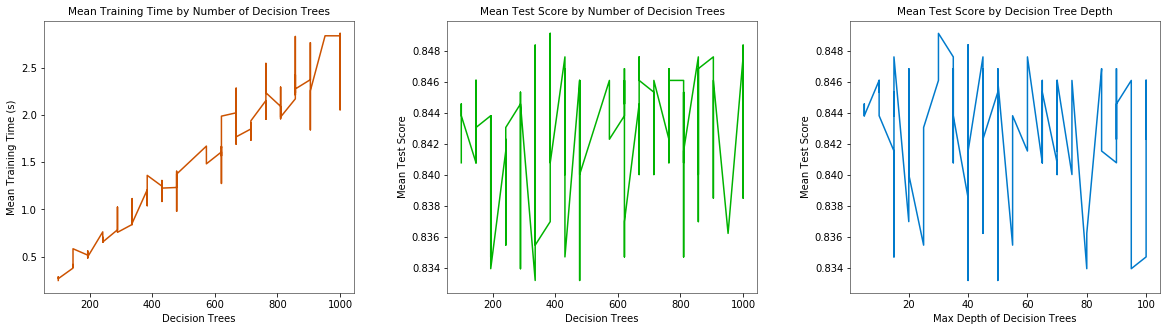

In [37]:
# Plot visuals for grid search
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(20, 5)

ax1.plot(estimators['param_n_estimators'], estimators['mean_fit_time'], color='#cc5200')
ax1.set_xlabel('Decision Trees')
ax1.set_ylabel('Mean Training Time (s)')
ax1.set_title('Mean Training Time by Number of Decision Trees', fontdict={'fontsize':10.5})

ax2.plot(estimators['param_n_estimators'], estimators['mean_test_score'], color='#00b300')
ax2.set_xlabel('Decision Trees')
ax2.set_ylabel('Mean Test Score')
ax2.set_title('Mean Test Score by Number of Decision Trees',fontdict={'fontsize':10.5})

ax3.plot(max_depths['param_max_depth'], max_depths['mean_test_score'], color='#007acc')
ax3.set_xlabel('Max Depth of Decision Trees')
ax3.set_ylabel('Mean Test Score')
ax3.set_title('Mean Test Score by Decision Tree Depth',fontdict={'fontsize':10.5})
plt.savefig('gridsearch.png', dpi=300)

In [38]:
# Get mean cross-validation score using best paramaters from grid search
forest = RandomForestClassifier(n_estimators=params['n_estimators'], min_samples_split=params['min_samples_split'], 
                                min_samples_leaf=params['min_samples_leaf'], max_features=params['max_features'], 
                                max_depth=params['max_depth'], bootstrap=params['bootstrap'], random_state=0)

In [39]:
scores = cross_val_score(forest, X_train, y_train, scoring='f1', cv=10)

In [40]:
print("Mean F1 Score: %f"%(scores.mean()))

Mean F1 Score: 0.916006


In [41]:
forest = RandomForestClassifier(n_estimators=params['n_estimators'], min_samples_split=params['min_samples_split'], 
                                min_samples_leaf=params['min_samples_leaf'], max_features=params['max_features'], 
                                max_depth=params['max_depth'], bootstrap=params['bootstrap'], random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=384,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [42]:
# Calculate metrics
y_pred = forest.predict(X_test)
accuracy  = metrics.accuracy_score(y_test, y_pred)
error     = 1 - metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average=None)
recall    = metrics.recall_score(y_test, y_pred, average=None)
f1_score  = metrics.f1_score(y_test, y_pred, average=None)
print('Accuracy:  ', '%0.3f'%(accuracy))
print('Error:     ', '%0.3f'%(error))
print('Precision: ', precision)
print('Recall:    ', recall)
print('F1 score:  ', f1_score)

Accuracy:   0.823
Error:      0.177
Precision:  [0.48571429 0.84557439]
Recall:     [0.17171717 0.9614561 ]
F1 score:   [0.25373134 0.8997996 ]
